In [1]:
import torch
import pickle
from IPython.display import Image, display

from torch.utils.data import Dataset
import torchvision.transforms as T 
import random
import numpy as np
import os

In [2]:
%%capture
'''
Action Genome Directory is organized as follows :
    ag
    |--annotations     
    |   |--frame_list.txt // list of frames to be sampled from videos
    |   |--object_bbox_and_relationship.pkl //
    |   |--object_classses.txt //idx_to_classes list of all classes
    |   |--person_bbox.pkl 
    |   |--relationship_classes.txt //idx_to_predicate list of all predicates
    |--frames
    |   |--0A8CF.mp4  //<video_name>.mp4
    |   |   |--000083.png //<sampled_frame_no>.png
    |   |   |--000084.png
             ****
    |--videos //all videos in mp4 format      
'''

In [3]:
root_path = '/mnt/Drive2/zeenat/ag/'

#### Explore frame_list.txt

In [4]:
with open(root_path + 'annotations/frame_list.txt', 'r') as f:
    frame_list = f.readlines()
f.close()

In [5]:
len(frame_list)

288782

#### Explore person_bbox.pkl

In [6]:
with open(root_path + 'annotations/person_bbox.pkl', 'rb') as f:
    person_bbox = pickle.load(f)
f.close()

In [7]:
len(person_bbox)

288782

In [8]:
person_bbox["001YG.mp4/000089.png"]

{'bbox': array([[ 24.29774 ,  71.443954, 259.23602 , 268.20288 ]], dtype=float32),
 'bbox_score': array([0.9960979], dtype=float32),
 'bbox_size': (480, 270),
 'bbox_mode': 'xyxy',
 'keypoints': array([[[149.51952 , 120.54931 ,   1.      ],
         [146.48587 , 111.43697 ,   1.      ],
         [141.09274 , 115.824394,   1.      ],
         [111.76759 , 123.58676 ,   1.      ],
         [112.44173 , 124.26174 ,   1.      ],
         [ 82.10537 , 154.6362  ,   1.      ],
         [113.45295 , 168.47343 ,   1.      ],
         [153.56436 , 207.96022 ,   1.      ],
         [162.66527 , 247.44699 ,   1.      ],
         [146.48587 , 149.91127 ,   1.      ],
         [216.59659 , 229.22232 ,   1.      ],
         [112.10466 , 243.73456 ,   1.      ],
         [163.3394  , 267.69662 ,   1.      ],
         [237.83205 , 202.56032 ,   1.      ],
         [239.18031 , 202.56032 ,   1.      ],
         [186.93436 , 219.0975  ,   1.      ],
         [220.9785  , 227.87234 ,   1.      ]]], dtype

In [9]:
sample_frame_path = '/mnt/Drive2/zeenat/ag/frames/001YG.mp4/000089.png'

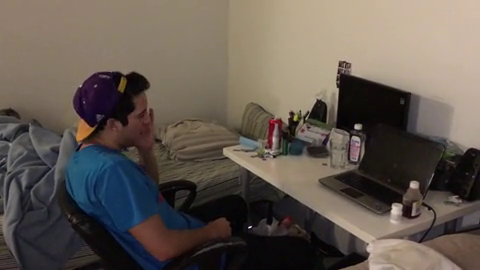

In [10]:
display(Image(filename= sample_frame_path))

#### Draw person bbox

In [12]:
import matplotlib.pyplot as plt
def plot_person_box(img,boxes):
    color = (0,255,0)
    for box in boxes:
        #box has coordinates x1,y1,x2,y2
        left = box[0]
        top = box[1]
        right = box[2] 
        bottom = box[3] 
        cv2.rectangle(img,(left, top), (right, bottom), color, 1)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # this converts it into RGB
    plt.imshow(rgb_img)
    plt.show()
    

Before rounding off:  [[ 24.29774   71.443954 259.23602  268.20288 ]]
After rounding off:  [[ 24  71 259 268]]


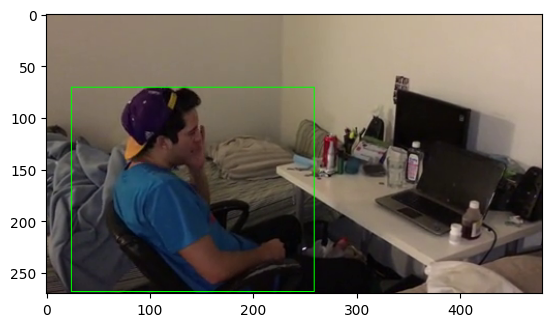

In [16]:
import cv2
sample_img = cv2.imread(sample_frame_path)
boxes =person_bbox["001YG.mp4/000089.png"]["bbox"]
print('Before rounding off: ',boxes)
boxes = np.round(boxes).astype(int)
print('After rounding off: ',boxes)
plot_person_box(sample_img,boxes)

#### Explore object_bbox_and_relationship.pkl

In [19]:
%%capture
'''
1. Each key in object_bbox contains list of objects in that frame. Key format <video.mp4/frame.png>
2. All object relationships are with respect to the person_bbox for this frame.
3. Some objects have key "visible" set to False, this means that these objects are not visible in the frame 
    or have a missing annotation. These are removed during training.
'''

In [20]:
with open(root_path+'annotations/object_bbox_and_relationship.pkl', 'rb') as f:
    object_bbox = pickle.load(f)
f.close()

In [21]:
objects = object_bbox['001YG.mp4/000089.png']
objects

[{'class': 'table',
  'bbox': (222.10317460317458,
   143.829365079365,
   257.77777777777777,
   101.11111111111109),
  'attention_relationship': ['unsure'],
  'spatial_relationship': ['in_front_of'],
  'contacting_relationship': ['not_contacting'],
  'metadata': {'tag': '001YG.mp4/table/000089', 'set': 'train'},
  'visible': True},
 {'class': 'chair',
  'bbox': (56.34126984126985,
   179.16666666666663,
   192.77777777777777,
   90.56890211160798),
  'attention_relationship': ['not_looking_at'],
  'spatial_relationship': ['beneath', 'behind'],
  'contacting_relationship': ['sitting_on', 'leaning_on'],
  'metadata': {'tag': '001YG.mp4/chair/000089', 'set': 'train'},
  'visible': True}]

#### Draw object boxes

In [22]:
def plot_object_box(img,boxes):
    color = (0,255,0)
    for box in boxes:
        #box has coordinates x,y,w,h
        left = box[0]
        top = box[1]
        right = box[2]+left 
        bottom = box[3]+top 
        cv2.rectangle(img,(left, top), (right, bottom), color, 1)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # this converts it into RGB
    plt.imshow(rgb_img)
    plt.show()

[222.1031746  143.82936508 257.77777778 101.11111111]
[ 56.34126984 179.16666667 192.77777778  90.56890211]


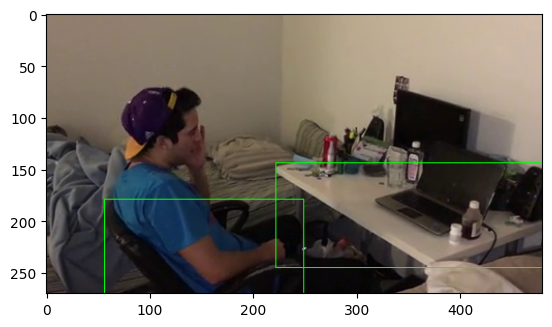

In [24]:
table_bbox = np.asarray(objects[0]['bbox'])
chair_bbox = np.asarray(objects[1]['bbox'])

print(table_bbox)
print(chair_bbox)

boxes = np.append(chair_bbox,table_bbox).reshape(-1,4)
boxes = np.round(boxes).astype(int)
sample_img = cv2.imread(sample_frame_path)
plot_object_box(sample_img,boxes)